<a href="https://colab.research.google.com/github/Yashaswini-Sridhar/Physic-Induced-NN/blob/main/air_quality_monitering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0, Loss: 1.2952359914779663
Epoch 100, Loss: 0.0010439379839226604
Epoch 200, Loss: 0.0006325324648059905
Epoch 300, Loss: 0.0005145127652212977
Epoch 400, Loss: 0.00044046781840734184
Epoch 500, Loss: 0.00038205611053854227
Epoch 600, Loss: 0.000333765841787681
Epoch 700, Loss: 0.0002939521800726652
Epoch 800, Loss: 0.0002615046687424183
Epoch 900, Loss: 0.0002353193995077163
Classification Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00        14
    Moderate       0.93      0.99      0.96       188

    accuracy                           0.93       202
   macro avg       0.47      0.50      0.48       202
weighted avg       0.87      0.93      0.89       202

Predicted AQI: 57.77, Air Quality: Moderate


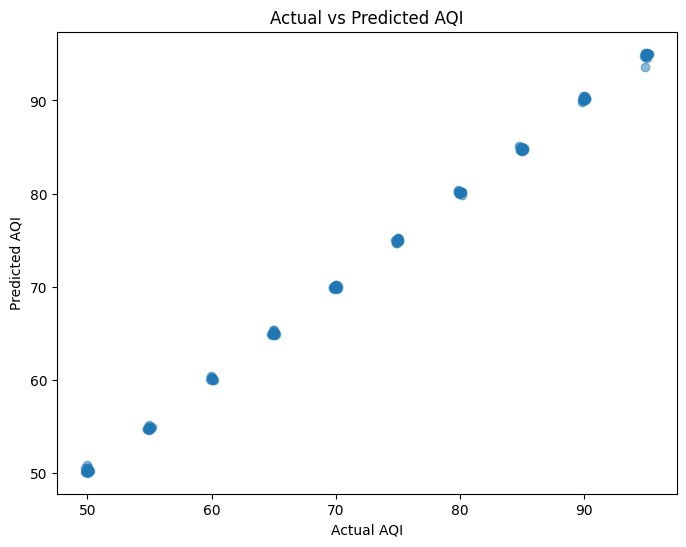

In [ ]:
# Step 1: Install required libraries
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install matplotlib

# Step 2: Copy and paste the code
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation=None)  # Output layer

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

# Define the physics-informed loss function
def pinn_loss(model, X, y):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        y_pred = model(X)  # Predict AQI
        # Add physical constraints here (if applicable)
        # For example, you could enforce relationships between pollutants and meteorological parameters
    # Compute the residual (difference between predicted and actual AQI)
    data_loss = tf.reduce_mean(tf.square(y_pred - y))
    return data_loss

# Generate synthetic data to augment the small dataset
def generate_synthetic_data(X, y, num_samples=1000):
    noise = np.random.normal(0, 0.1, size=(num_samples, X.shape[1]))
    X_synthetic = np.vstack([X] * (num_samples // len(X))) + noise
    y_synthetic = np.vstack([y] * (num_samples // len(y))) + np.random.normal(0, 0.1, size=(num_samples, 1))
    return X_synthetic, y_synthetic

# Load and preprocess the dataset
def load_and_preprocess_data():
    # Example: Load a small dataset (replace with your own data)
    data = pd.DataFrame({
        'PM2.5': [35, 40, 50, 60, 70, 80, 90, 100, 120, 150],
        'PM10': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
        'NO2': [20, 22, 25, 30, 35, 40, 45, 50, 55, 60],
        'O3': [30, 32, 35, 40, 45, 50, 55, 60, 65, 70],
        'SO2': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'CO': [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1],
        'Temperature': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
        'Humidity': [60, 62, 65, 70, 75, 80, 85, 90, 95, 100],
        'Wind Speed': [10, 12, 15, 20, 25, 30, 35, 40, 45, 50],
        'Wind Direction': [180, 190, 200, 210, 220, 230, 240, 250, 260, 270],
        'AQI': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]  # Example AQI values
    })
    X = data.drop(columns=['AQI']).values
    y = data['AQI'].values.reshape(-1, 1)
    return X, y

# Train the PINN model
def train_pinn(model, optimizer, X_train, y_train, epochs=1000):
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = pinn_loss(model, X_train, y_train)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Classify air quality based on AQI levels
def classify_air_quality(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 200:
        return "Unhealthy"
    else:
        return "Dangerous"

# Main function
def main():
    # Load and preprocess data
    X, y = load_and_preprocess_data()

    # Generate synthetic data to augment the small dataset
    X_synthetic, y_synthetic = generate_synthetic_data(X, y, num_samples=1000)

    # Combine real and synthetic data
    X_combined = np.vstack([X, X_synthetic])
    y_combined = np.vstack([y, y_synthetic])

    # Normalize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_combined = scaler_X.fit_transform(X_combined)
    y_combined = scaler_y.fit_transform(y_combined)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = PINN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    train_pinn(model, optimizer, X_train, y_train, epochs=1000)

    # Evaluate the model
    y_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
    y_pred = scaler_y.inverse_transform(y_pred)  # Rescale to original units
    y_test = scaler_y.inverse_transform(y_test)  # Rescale to original units

    # Classify air quality
    y_pred_class = [classify_air_quality(aqi) for aqi in y_pred.flatten()]
    y_test_class = [classify_air_quality(aqi) for aqi in y_test.flatten()]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test_class, y_pred_class))

    # Example: Predict air quality for new input
    new_input = np.array([[40, 55, 25, 35, 8, 1.5, 28, 70, 15, 200]])  # Example input: [PM2.5, PM10, NO2, O3, SO2, CO, Temperature, Humidity, Wind Speed, Wind Direction]
    new_input_scaled = scaler_X.transform(new_input)
    aqi_pred = model(tf.convert_to_tensor(new_input_scaled, dtype=tf.float32)).numpy()
    aqi_pred = scaler_y.inverse_transform(aqi_pred)  # Rescale to original units
    air_quality = classify_air_quality(aqi_pred[0][0])
    print(f"Predicted AQI: {aqi_pred[0][0]:.2f}, Air Quality: {air_quality}")

    # Return y_test and y_pred for plotting
    return y_test, y_pred

# Run the main function and get y_test and y_pred
y_test, y_pred = main()

# Plot the results
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI')
plt.show()

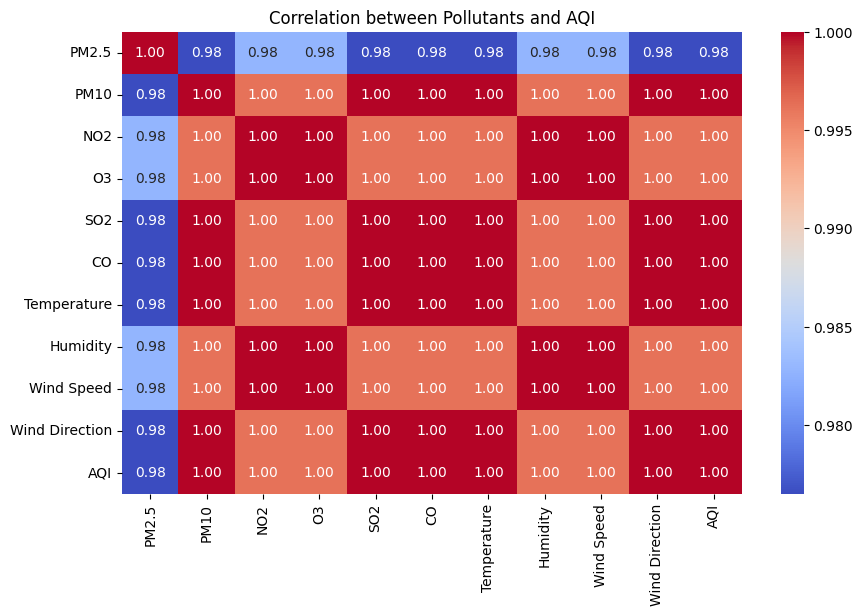

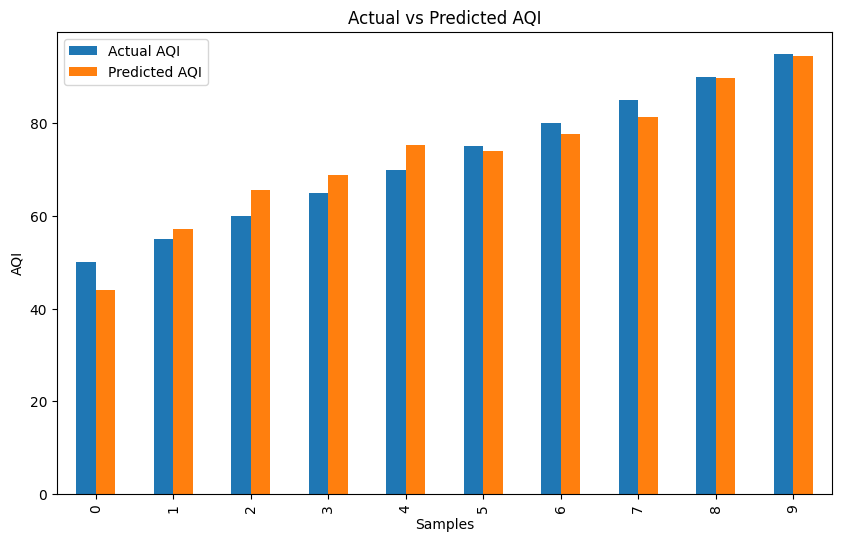

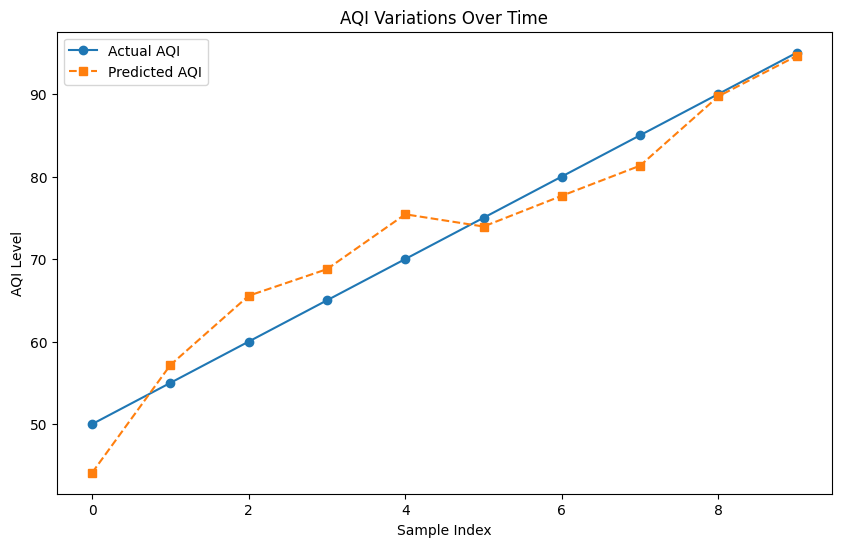

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Load data
def load_data():
    return pd.DataFrame({
        'PM2.5': [35, 40, 50, 60, 70, 80, 90, 100, 120, 150],
        'PM10': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
        'NO2': [20, 22, 25, 30, 35, 40, 45, 50, 55, 60],
        'O3': [30, 32, 35, 40, 45, 50, 55, 60, 65, 70],
        'SO2': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'CO': [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1],
        'Temperature': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
        'Humidity': [60, 62, 65, 70, 75, 80, 85, 90, 95, 100],
        'Wind Speed': [10, 12, 15, 20, 25, 30, 35, 40, 45, 50],
        'Wind Direction': [180, 190, 200, 210, 220, 230, 240, 250, 260, 270],
        'AQI': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
    })

data = load_data()

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation between Pollutants and AQI")
plt.show()

# Bar chart of actual vs. predicted AQI (mock data for visualization)
y_test = np.array([50, 55, 60, 65, 70, 75, 80, 85, 90, 95])
y_pred = y_test + np.random.normal(0, 5, size=y_test.shape)

df_results = pd.DataFrame({'Actual AQI': y_test, 'Predicted AQI': y_pred})
df_results.plot(kind='bar', figsize=(10, 6))
plt.xlabel("Samples")
plt.ylabel("AQI")
plt.title("Actual vs Predicted AQI")
plt.show()

# Line plot for AQI trend
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, marker='o', label='Actual AQI')
plt.plot(range(len(y_pred)), y_pred, marker='s', linestyle='dashed', label='Predicted AQI')
plt.xlabel("Sample Index")
plt.ylabel("AQI Level")
plt.title("AQI Variations Over Time")
plt.legend()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.0 MB/s eta 0:00:00
Epoch 0, Loss: 0.11178745329380035
Epoch 100, Loss: 0.000834271777421236
Epoch 200, Loss: 0.0005504236905835569
Epoch 300, Loss: 0.00035143730929121375
Epoch 400, Loss: 0.00023877098283264786
Epoch 500, Loss: 0.00018572411499917507
Epoch 600, Loss: 0.00015991299005690962
Epoch 700, Loss: 0.00014310592086985707
Epoch 800, Loss: 0.00012954804697073996
Epoch 900, Loss: 0.00012378919927868992


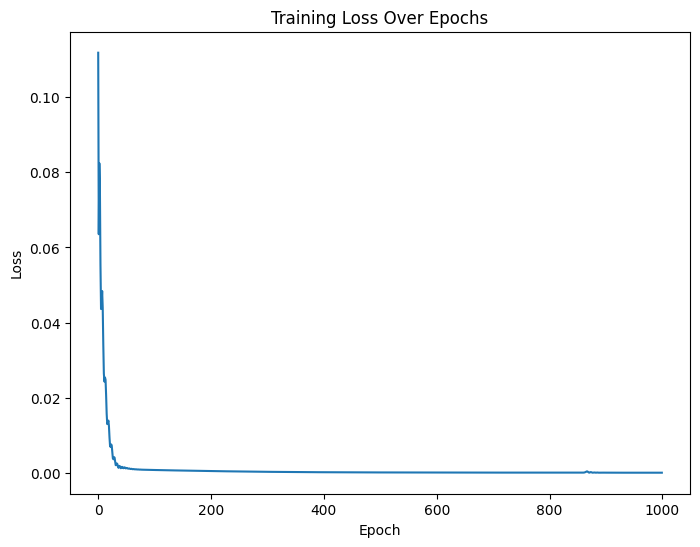

Classification Report:
              precision    recall  f1-score   support

        Good       0.00      0.00      0.00        14
    Moderate       0.93      1.00      0.96       188

    accuracy                           0.93       202
   macro avg       0.47      0.50      0.48       202
weighted avg       0.87      0.93      0.90       202



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


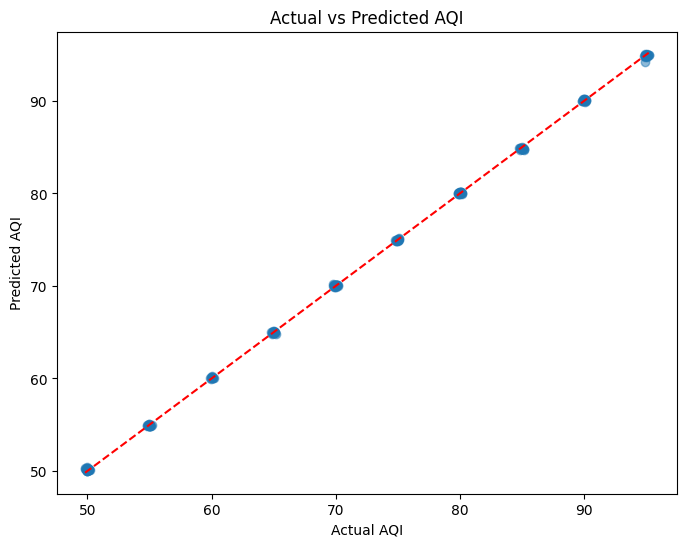

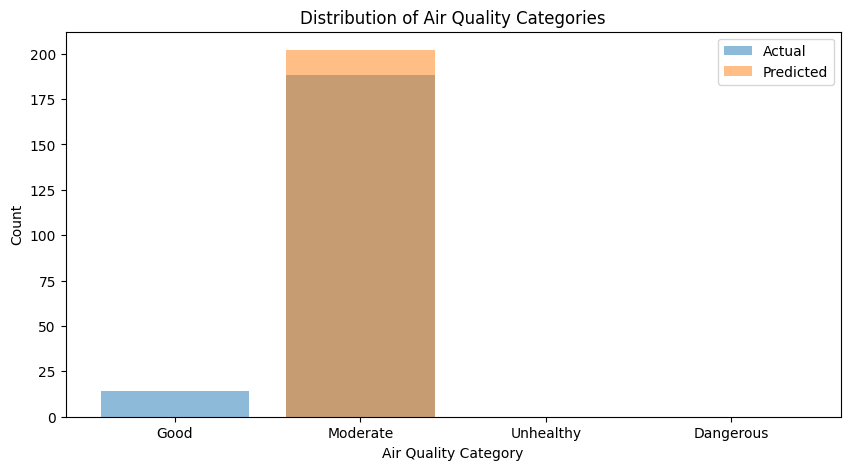

interactive(children=(FloatSlider(value=40.0, description='PM2_5', max=200.0, step=1.0), FloatSlider(value=55.…

In [ ]:
# Step 1: Install required libraries
!pip install tensorflow
!pip install scikit-learn
!pip install pandas
!pip install matplotlib
!pip install ipywidgets  # For interactive input

# Step 2: Import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Define the neural network architecture
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation=None)  # Output layer

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

# Define the physics-informed loss function
def pinn_loss(model, X, y):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(X)
        y_pred = model(X)  # Predict AQI
        # Add physical constraints here (if applicable)
        # For example, you could enforce relationships between pollutants and meteorological parameters
    # Compute the residual (difference between predicted and actual AQI)
    data_loss = tf.reduce_mean(tf.square(y_pred - y))
    return data_loss

# Generate synthetic data to augment the small dataset
def generate_synthetic_data(X, y, num_samples=1000):
    noise = np.random.normal(0, 0.1, size=(num_samples, X.shape[1]))
    X_synthetic = np.vstack([X] * (num_samples // len(X))) + noise
    y_synthetic = np.vstack([y] * (num_samples // len(y))) + np.random.normal(0, 0.1, size=(num_samples, 1))
    return X_synthetic, y_synthetic

# Load and preprocess the dataset
def load_and_preprocess_data():
    # Example: Load a small dataset (replace with your own data)
    data = pd.DataFrame({
        'PM2.5': [35, 40, 50, 60, 70, 80, 90, 100, 120, 150],
        'PM10': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95],
        'NO2': [20, 22, 25, 30, 35, 40, 45, 50, 55, 60],
        'O3': [30, 32, 35, 40, 45, 50, 55, 60, 65, 70],
        'SO2': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
        'CO': [1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.1],
        'Temperature': [25, 26, 27, 28, 29, 30, 31, 32, 33, 34],
        'Humidity': [60, 62, 65, 70, 75, 80, 85, 90, 95, 100],
        'Wind Speed': [10, 12, 15, 20, 25, 30, 35, 40, 45, 50],
        'Wind Direction': [180, 190, 200, 210, 220, 230, 240, 250, 260, 270],
        'AQI': [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]  # Example AQI values
    })
    X = data.drop(columns=['AQI']).values
    y = data['AQI'].values.reshape(-1, 1)
    return X, y

# Train the PINN model
def train_pinn(model, optimizer, X_train, y_train, epochs=1000):
    losses = []  # Store losses for visualization
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            loss = pinn_loss(model, X_train, y_train)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")
        losses.append(loss.numpy())

    # Plot training loss
    plt.figure(figsize=(8, 6))
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.show()

# Classify air quality based on AQI levels
def classify_air_quality(aqi):
    if aqi <= 50:
        return "Good"
    elif aqi <= 100:
        return "Moderate"
    elif aqi <= 200:
        return "Unhealthy"
    else:
        return "Dangerous"

# Main function
def main():
    # Load and preprocess data
    X, y = load_and_preprocess_data()

    # Generate synthetic data to augment the small dataset
    X_synthetic, y_synthetic = generate_synthetic_data(X, y, num_samples=1000)

    # Combine real and synthetic data
    X_combined = np.vstack([X, X_synthetic])
    y_combined = np.vstack([y, y_synthetic])

    # Normalize the data
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X_combined = scaler_X.fit_transform(X_combined)
    y_combined = scaler_y.fit_transform(y_combined)

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_combined, y_combined, test_size=0.2, random_state=42)

    # Initialize and train the model
    model = PINN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    train_pinn(model, optimizer, X_train, y_train, epochs=1000)

    # Evaluate the model
    y_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
    y_pred = scaler_y.inverse_transform(y_pred)  # Rescale to original units
    y_test = scaler_y.inverse_transform(y_test)  # Rescale to original units

    # Classify air quality
    y_pred_class = [classify_air_quality(aqi) for aqi in y_pred.flatten()]
    y_test_class = [classify_air_quality(aqi) for aqi in y_test.flatten()]

    # Print classification report
    print("Classification Report:")
    print(classification_report(y_test_class, y_pred_class))

    # Plot actual vs predicted AQI
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')  # Regression line
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title('Actual vs Predicted AQI')
    plt.show()

    # Plot air quality classification distribution
    categories = ["Good", "Moderate", "Unhealthy", "Dangerous"]
    y_test_counts = [y_test_class.count(cat) for cat in categories]
    y_pred_counts = [y_pred_class.count(cat) for cat in categories]

    plt.figure(figsize=(10, 5))
    plt.bar(categories, y_test_counts, alpha=0.5, label='Actual')
    plt.bar(categories, y_pred_counts, alpha=0.5, label='Predicted')
    plt.xlabel('Air Quality Category')
    plt.ylabel('Count')
    plt.title('Distribution of Air Quality Categories')
    plt.legend()
    plt.show()

    # Return y_test and y_pred for further use
    return y_test, y_pred, model, scaler_X, scaler_y

# Run the main function and get y_test, y_pred, model, and scalers
y_test, y_pred, model, scaler_X, scaler_y = main()

# Interactive input for predictions
def predict_aqi(PM2_5, PM10, NO2, O3, SO2, CO, Temperature, Humidity, Wind_Speed, Wind_Direction):
    new_input = np.array([[PM2_5, PM10, NO2, O3, SO2, CO, Temperature, Humidity, Wind_Speed, Wind_Direction]])
    new_input_scaled = scaler_X.transform(new_input)
    aqi_pred = model(tf.convert_to_tensor(new_input_scaled, dtype=tf.float32)).numpy()
    aqi_pred = scaler_y.inverse_transform(aqi_pred)  # Rescale to original units
    air_quality = classify_air_quality(aqi_pred[0][0])
    print(f"Predicted AQI: {aqi_pred[0][0]:.2f}, Air Quality: {air_quality}")

# Create interactive widgets
widgets.interact(
    predict_aqi,
    PM2_5=widgets.FloatSlider(min=0, max=200, step=1, value=40),
    PM10=widgets.FloatSlider(min=0, max=200, step=1, value=55),
    NO2=widgets.FloatSlider(min=0, max=100, step=1, value=25),
    O3=widgets.FloatSlider(min=0, max=100, step=1, value=35),
    SO2=widgets.FloatSlider(min=0, max=20, step=1, value=8),
    CO=widgets.FloatSlider(min=0, max=5, step=0.1, value=1.5),
    Temperature=widgets.FloatSlider(min=0, max=50, step=1, value=28),
    Humidity=widgets.FloatSlider(min=0, max=100, step=1, value=70),
    Wind_Speed=widgets.FloatSlider(min=0, max=50, step=1, value=15),
    Wind_Direction=widgets.FloatSlider(min=0, max=360, step=1, value=200)
);

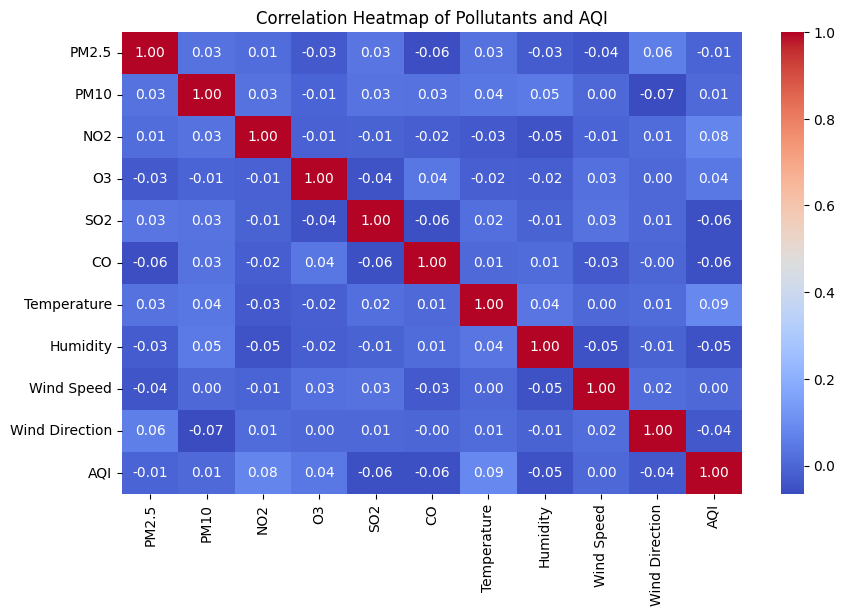

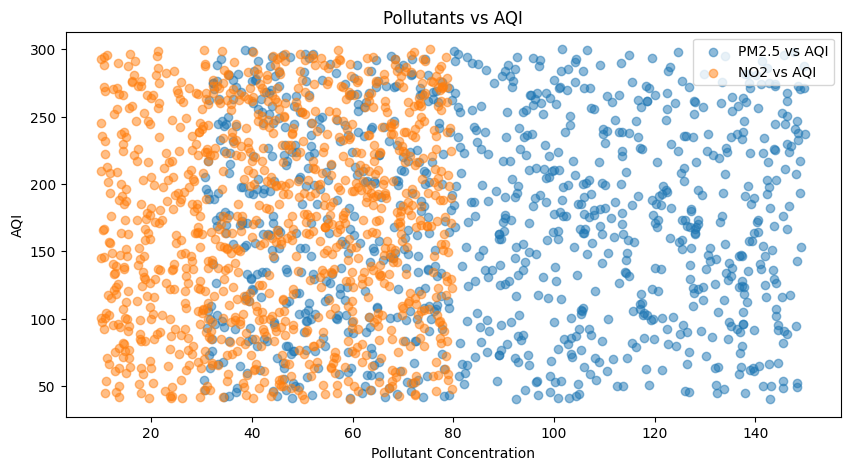

Epoch 0, Loss: 1.6547050476074219
Epoch 100, Loss: 0.8516072034835815
Epoch 200, Loss: 0.606427788734436
Epoch 300, Loss: 0.2787036895751953
Epoch 400, Loss: 0.07064144313335419
Epoch 500, Loss: 0.013097086921334267
Epoch 600, Loss: 0.0024497336708009243
Epoch 700, Loss: 0.0004644438740797341
Epoch 800, Loss: 0.00012542908370960504
Epoch 900, Loss: 1.936246371769812e-05


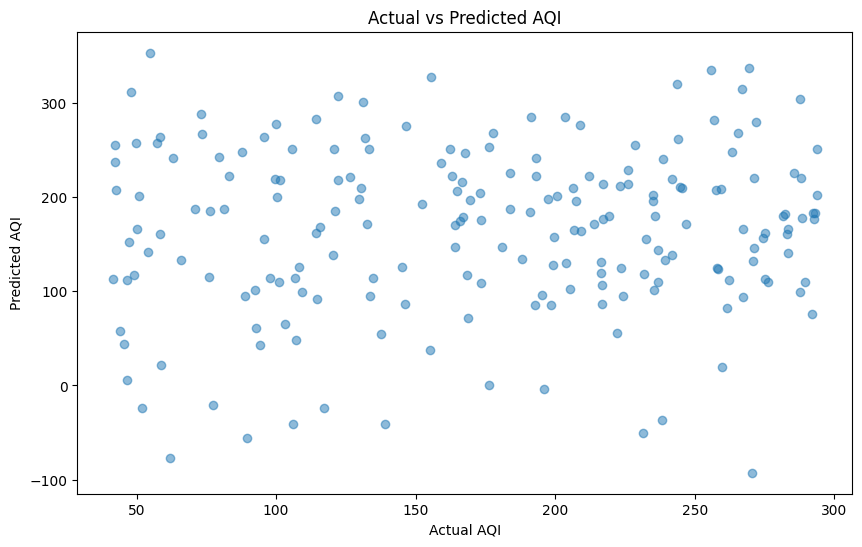

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd

# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Load and preprocess the dataset
def load_and_preprocess_data():
    data = pd.DataFrame({
        'PM2.5': np.random.uniform(30, 150, 1000),
        'PM10': np.random.uniform(40, 200, 1000),
        'NO2': np.random.uniform(10, 80, 1000),
        'O3': np.random.uniform(20, 100, 1000),
        'SO2': np.random.uniform(2, 20, 1000),
        'CO': np.random.uniform(0.5, 3, 1000),
        'Temperature': np.random.uniform(20, 40, 1000),
        'Humidity': np.random.uniform(50, 100, 1000),
        'Wind Speed': np.random.uniform(5, 30, 1000),
        'Wind Direction': np.random.uniform(0, 360, 1000),
        'AQI': np.random.uniform(40, 300, 1000)
    })
    X = data.drop(columns=['AQI']).values
    y = data['AQI'].values.reshape(-1, 1)
    return data, X, y

# Data Visualization
def visualize_data(data):
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Heatmap of Pollutants and AQI")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.scatter(data['PM2.5'], data['AQI'], alpha=0.5, label='PM2.5 vs AQI')
    plt.scatter(data['NO2'], data['AQI'], alpha=0.5, label='NO2 vs AQI')
    plt.xlabel('Pollutant Concentration')
    plt.ylabel('AQI')
    plt.title('Pollutants vs AQI')
    plt.legend()
    plt.show()

# Define the PINN model
class PINN(tf.keras.Model):
    def __init__(self):
        super(PINN, self).__init__()
        self.dense1 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense2 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense3 = tf.keras.layers.Dense(50, activation='tanh')
        self.dense4 = tf.keras.layers.Dense(1, activation=None)

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dense4(x)

# Train the PINN model
def train_pinn(model, optimizer, X_train, y_train, epochs=1000):
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            y_pred = model(X_train)
            loss = tf.reduce_mean(tf.square(y_pred - y_train))
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.numpy()}")

# Main function
def main():
    data, X, y = load_and_preprocess_data()
    visualize_data(data)

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = PINN()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    train_pinn(model, optimizer, X_train, y_train, epochs=1000)

    y_pred = model(tf.convert_to_tensor(X_test, dtype=tf.float32)).numpy()
    y_pred = scaler_y.inverse_transform(y_pred)
    y_test = scaler_y.inverse_transform(y_test)

    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual AQI')
    plt.ylabel('Predicted AQI')
    plt.title('Actual vs Predicted AQI')
    plt.show()

    return y_test, y_pred

# Run the main function
if __name__ == "__main__":
    y_test, y_pred = main()
